In [45]:
import math
def tcp(n, flops, p):
    return flops / (n * p)
def tcm(n, weights, b, c):
    return 2 * (weights / b + c) * math.log (n, 2)
def t(n, weights, flops, b, c, p):
    return tcp(n, flops, p) + tcm(n, weights, b, c)
def weights(layers):
    w = 0
    for i in range(1, len(layers)):
        w = w + layers[i - 1] * layers[i]
    return w
def flops(layers):
    return 6 * weights(layers)


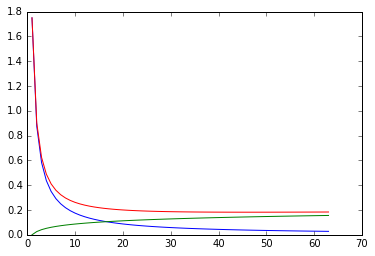

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
n = np.arange(1, 64)
flops = 7e12
p = 4e12
weights = 249 * 1024 * 1024 * 8
b = 20 * 8 * 1e9
c = 0.0
vtcp = np.vectorize(tcp)
vtcm = np.vectorize(tcm)
vt = np.vectorize(t)
tcomp = vtcp(n, flops, p)
tcomm = vtcm(n, weights, b, c)
titer = vt(n, weights, flops, b, c, p)
plt.plot(n,tcomp)
plt.plot(n,tcomm)
plt.plot(n, titer)
#plt.ylabel('some numbers')